## Laboratorium 13


## Metody wykrywania ruchu: przepływ optyczny (_optical flow_)

### Wstęp

Na poprzednich laboratoriach poznaliśmy podstawowe metody przetwarzania obrazów, a więc dwuwymiarowych sygnałów przestrzennych. Jednak w praktyce czasami dysponujemy materiałem wideo, a więc sygnałami _trójwymiarowymi_, gdzie trzecim wymiarem jest czas. Oczywiście, można takie dane traktować jako po prostu sekwencję niezależnych obrazów - i wtedy działają wszystkie poznane dotychczas metody. Jednak dlaczego by nie wykorzystać tej dziedziny czasowej do przetwarzania sygnału? Intuicyjnie czujemy, że jeśli jakiś rejon obrazu przesunął się w czasie, to prawdopodobnie ma on inne _znaczenie_ niż rejon, który pozostał w tym samym miejscu, lub przesunął w innym kierunku czy z inną szybkością. Jeśli zatem jesteśmy w stanie wykryć to przesunięcie - czyli po prostu _ruch_ - to otrzymamy pewną informację o zawartości obrazu (wideo). Na przykład, będziemy w stanie oddzielić poruszające się obiekty od stacjonarnego tła, albo oddzielić inaczej poruszające się obiekty.

Najpowszechniejszą metodą do automatycznej detekcji ruchu jest metoda przepływu optycznego (ang. _optical flow_). Pominiemy w tej instrukcji matematyczne podstawy tej metody - te są wystarczająco dobrze wyłożone w [artykule z dokumentacji OpenCV](https://docs.opencv.org/3.4/d4/dee/tutorial_optical_flow.html), do którego lektury namawiam. Wiedzieć należy na pewno, że istnieją dwie główne odmiany metody przepływu optycznego:
* przepływ rzadki (_sparse_) - gdzie ruch wykrywany jest tylko dla pewnego zbioru punktów zainteresowania w obrębie obrazu (tym zajmiemy się na przyszłych zajęciach),
* przepływ gęsty (_dense_) - gdzie przesunięcie pomiędzy klatkami określane jest dla każdego piksela. Na tym podejściu skupimy się w ramach tego laboratorium.

W ramach obu odmian występuje pewna liczba konkretnych metod obliczeniowych, w zależności od konkretnego podejścia do rozwiązywania równania ruchu. Na tych zajęciach wykorzystamy [algorytm Farnebacka](http://www.diva-portal.org/smash/get/diva2:273847/FULLTEXT01.pdf) - głównie dlatego, że jego gotowa implementacja znajduje się w pakiecie OpenCV.

### Podejście

Większość algorytmów optical flow operuje na parze klatek, znajdując translację pomiędzy jedną a drugą. Jeśli więc interesuje nas przetwarzanie ciągłego strumienia wideo, praca przebiegać będzie na zasadzie dwuelementowej kolejki, tzn. zawsze patrzymy na klatkę obecną i poprzednią.

OpenCV oferuje banalnie prosty a zarazem potężny interfejs do obsługi strumieni wideo: [`cv2.VideoCapture`](https://docs.opencv.org/3.4/d8/dfe/classcv_1_1VideoCapture.html), za pomocą którego w ten sam sposób możemy obsługiwać pliki wideo w różnym kodowaniu, urządzenia wideo (np. kamerkę w laptopie) czy nawet wideo w protokole IP (choć występują pewne różnice z punktu widzenia użycia, jeśli korzystamy z zasobu hardware'owego działającego w czasie rzeczywistym). Idea jest prosta:
* tworzymy obiekt `cv2.VideoCapture` w odpowiedni sposób,
* pobieramy poszczególne klatki za pomocą metody [`VideoCapture::read`](https://docs.opencv.org/3.4/d8/dfe/classcv_1_1VideoCapture.html#a473055e77dd7faa4d26d686226b292c1).

Metoda `read` wykonuje całą pracę (odczytanie danych, dekodowanie strumienia wideo) i zwraca klatkę jako obraz w standardowym formacie OpenCV (a także flagę, czy w ogóle udało się pozyskać dane - krotka (flaga, klatka)). Zatem, aby pozyskać pierwszą klatkę z pliku wideo wystarczy:
```python
vid = cv2.VideoCapture("back.mp4")
r, frame = vid.read()
```

Drobnym ograniczeniem VideoCapture jest to, że nie ma możliwości cofnięcia się do poprzednio pobranej klatki (co jest naturalne w przypadku korzystania z fizycznego urządzenia do akwizycji, a może trochę mniej gdy czytamy z pliku). Jeśli potrzebny jest powrót do początku pliku wideo, niestety konieczne jest zamknięcie strumienia (`VideoCapture::release`) i ponowne otwarcie (`::open`).

Aby obliczyć (gęsty) przepływ optyczny pomiędzy dwiema klatkami, wykorzystamy algorytm Farnebacka, zaimplementowany w OpenCV w funkcji [`cv2.calcOpticalFlowFarneback`](https://docs.opencv.org/3.4/dc/d6b/group__video__track.html#ga5d10ebbd59fe09c5f650289ec0ece5af). Przyjmuje ona parę obrazów **w skali szarości**, opcjonalny argument `flow` (rozwiązanie można zainicjować poprzednio wyliczonym przepływem, jeśli nim dysponujemy), a następnie szereg parametrów sterujących metodą; m.in. można wykorzystać piramidyzację obrazów (rekomendowane `pyr_size` $=3$) czy określić rozmiar okna detekcji `winsize`. Sensowne pierwsze wartości dla argumentów podane są w dokumentacji.

Algorytm Farnebacka zwraca przepływ w formie obrazu o wymiarach przestrzennych równych obrazom wejściowym i dwóch kanałach, zawierających przesunięcie odpowiednio w osi $x$ i $y$. Można więc przetwarzać te dane dalej, np. obliczając kąt przesunięcia czy całkowitą odległość (i dalej, np. określić prędkość ruchu) - vide np. `cv2.cartToPolar`.

---

In [1]:
import cv2
import numpy as np
import seaborn as sns 
import pandas as ps
import matplotlib.pyplot as plt

from time import sleep
from IPython.display import display, Image

#### Zadanie 1a (1.0 pkt | 0.0 pkt)
Otwórz wideo `kick.mp4` lub `back.mp4` i pobierz kilka klatek. Przewiń do interesującego Cię momentu - tak, aby uzyskać dwie klatki, na których widać ruch (pro-tip: znając framerate materiału (~25fps) i czas, w którym rozpoczyna się interesujący fragment, możesz w pętli "skonsumować" odpowiednią ilość klatek).  
Wykorzystaj algorytm Farnebacka do obliczenia przepływu pomiędzy klatkami. Wynik zaprezentuj w postaci całkowitego przesunięcia. W zależności od wybranego momentu w wideo, możesz spodziewać się uzyskania wyraźnych obszarów.

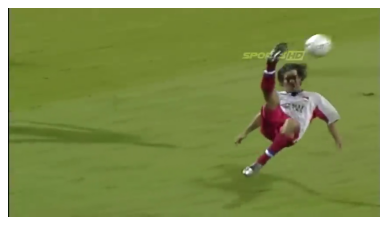

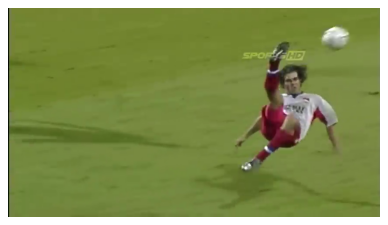

In [2]:
def show_image(image, dpi=200):
    plt.figure(dpi=dpi)
    plt.imshow(image, cmap="gray" if len(image.shape) == 2 else None)
    plt.axis("off");
    
def get_2_frames(filename, skip=0):
    video = cv2.VideoCapture(filename)
    prev_frame = None
    r, frame = video.read()
    for _ in range(skip + 1):
        prev_frame = frame
        r, frame = video.read()
    video.release()
    return prev_frame[..., ::-1], frame[..., ::-1]

prev_frame, frame = get_2_frames('dane/kick.mp4', skip=35)
show_image(prev_frame, dpi=80)
show_image(frame, dpi=80)

In [3]:
def play_video(filename, delay=0.02, skip=0, duration=None, function=None):
    display_handle=display(None, display_id=True)
    try:
        while True:
            video = cv2.VideoCapture(filename)
            prev_frame = None
            r, frame = video.read()
            
            for _ in range(skip):
                prev_frame = frame
                r, frame = video.read()
                
            num = 0
            
            while r:
                if function is not None and prev_frame is not None:
                    new_frame = function(prev_frame[...,::-1], frame[...,::-1])
                else:
                    new_frame = frame.copy()
                    
                prev_frame = frame
                
                _, new_frame = cv2.imencode('.jpeg', new_frame)
                display_handle.update(Image(data=new_frame.tobytes()))
                
                r, frame = video.read()
                
                num += 1
                
                if duration is not None and num >= duration:
                    break
                
                sleep(delay)
    except KeyboardInterrupt:
        pass
    finally:
        video.release()
        display_handle.update(None)
        
        
play_video('dane/kick.mp4')

None

In [4]:
def flow(prev, next, winsize=15):
    flow = cv2.calcOpticalFlowFarneback(
        prev=cv2.cvtColor(prev, cv2.COLOR_RGB2GRAY),
        next=cv2.cvtColor(next, cv2.COLOR_RGB2GRAY),
        flow=None, 
        pyr_scale=0.5,
        levels=3,
        winsize=winsize,
        iterations=3,
        poly_n=5, 
        poly_sigma=1.2,
        flags=0,
    )
    mag, ang = cv2.cartToPolar(
        flow[..., 0],
        flow[..., 1],
    )
    return mag

def flow_mask(prev_frame, next_frame, gain=5):
    image = flow(prev_frame, next_frame)
    mask = np.zeros_like(next_frame)
    mask[..., 0] = image
    frame = cv2.add(mask * gain, next_frame.copy())
    return frame[..., ::-1]

In [5]:
play_video('dane/kick.mp4', function=flow_mask)

None

In [6]:
play_video('dane/back.mp4', function=flow_mask)

None

[h264 @ 0x559420163a80] mmco: unref short failure
[h264 @ 0x559420163a80] mmco: unref short failure


#### Zadanie 1b (0.0 pkt | 1.0 pkt)

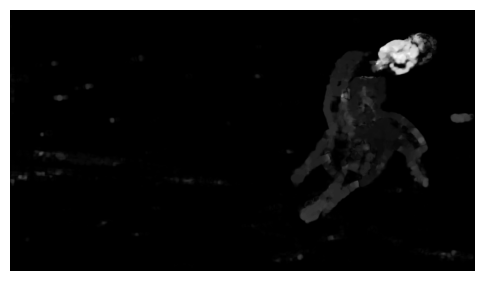

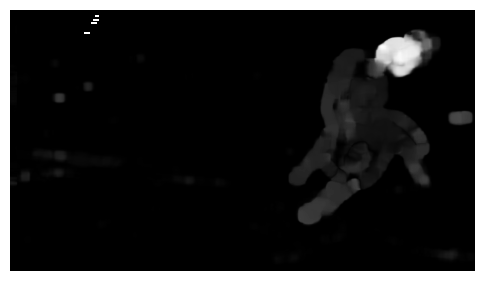

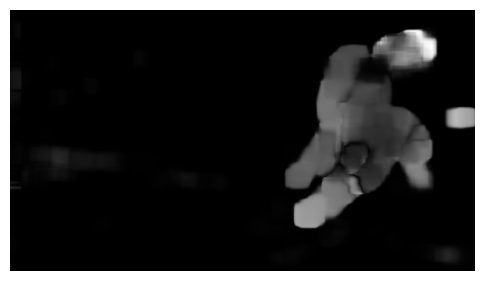

In [7]:
show_image(flow(prev_frame, frame, winsize=5), dpi=100)
show_image(flow(prev_frame, frame, winsize=15), dpi=100)
show_image(flow(prev_frame, frame, winsize=30), dpi=100)

Komentarz 1:

Mały rozmiar okna ($win\_size=5$) wykrył bardzo dobrze obszar kopniętej piłki, a sylwetka piłkarza jest bardzo słabo wykrywana. Wraz ze wzrostem tego parametru algrytm lepiej wykrywa wszystkie ruchome elementy na obrazie, a sama maska jest rozmyta w stosunku do poprzednich.

---

### Zadanie 2 (1.0 pkt | 1.0 pkt)

Powtórz powyższy eksperyment na materiale `shot.mp4` (przewiń materiał do momentu po uderzeniu białej bili, ok. 20-25 klatek; framerate wynosi tu ok. 15fps).  
*W czym leży trudność? Co jest ograniczeniem metody?*

In [8]:
play_video('dane/shot.mp4', skip=18, duration=13, delay=0.5, function=flow_mask)

None

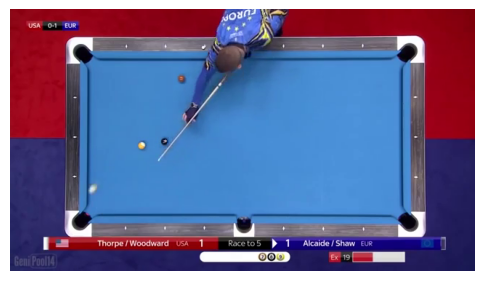

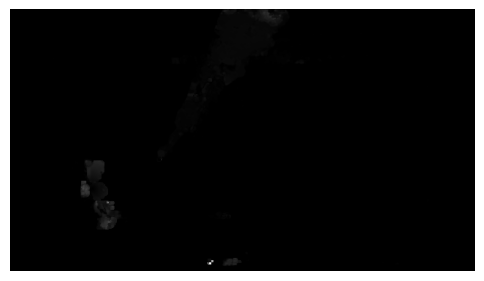

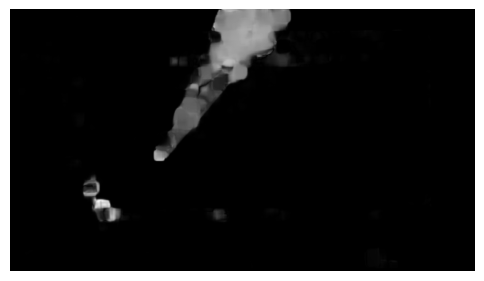

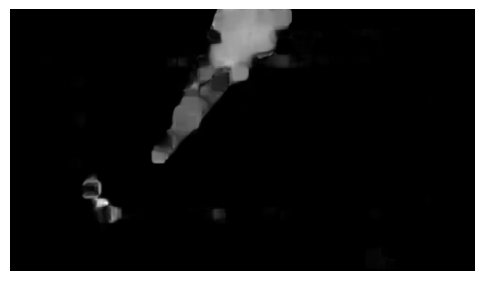

In [9]:
prev_frame2, frame2 = get_2_frames('dane/shot.mp4', skip=23)
show_image(frame2, dpi=100)
show_image(flow(prev_frame2, frame2, winsize=2), dpi=100)
show_image(flow(prev_frame2, frame2, winsize=10), dpi=100)
show_image(flow(prev_frame2, frame2, winsize=15), dpi=100)

Komentarz 2:

Na prezentowanym nagraniu między następującymi po sobie klatkami nagrania `shot.mp4` jest widoczny bardzo szybki ruch bili po stole bilardowym. Łatwo zauważyć, że przy bardzo małym oknie ruch jest niemal niewykryty. Przy większych wartościach $win\_size$ ruch jest wykrywynay, ale nie jest on płynny jak w przypadku poprzedniego nagrania. Ponadto bila jest wykrywana dwa razy, tam gdzie się pojawiła i tam skąd zniknęła. Algorytm w tym przypadku nie jest w stanie wykryć toru ruchu bili po stole.
Podsumowując, metoda _Farnebecka_ nie radzi sobie dobrze z wykrywaniem przemieszczenia bardzo szybkich, dynamicznych ruchów obiektów między dwoma kolejnymi klatkami nagrania. Aby uniiknąć takiej sytuacji, konieczne jest zwiększenie liczby klatek (fps) w nagraniu.

### Zadanie 3 (1.0 pkt | 0.0 pkt)

Powróć do takiego przypadku i konfiguracji algorytmu, dla którego uzyskane przez Ciebie wyniki były satysfakcjonujące. Przypomnij sobie zajęcia dotyczące np. segmentacji i wykorzystaj informację o przepływie optycznym do oddzielenia na obrazie obiektów od tła (metoda zupełnie dowolna).

In [10]:
def flow_mask_segment(prev_frame, next_frame, gain=5, threshold=0.9):
    image = flow(prev_frame, next_frame)
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    mask = ((image <= threshold) * 255).astype(np.uint8)
    frame = cv2.subtract(next_frame.copy(), mask)
    return frame[..., ::-1]

In [11]:
play_video('dane/shot.mp4', skip=18, duration=10, delay=0.5, function=flow_mask_segment)

None

In [12]:
play_video('dane/kick.mp4', skip=0, duration=None, delay=0.01, function=flow_mask_segment)

None

In [13]:
flow = cv2.calcOpticalFlowFarneback(
    prev=cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY),
    next=cv2.cvtColor(prev_frame, cv2.COLOR_RGB2GRAY),
    flow=None, 
    pyr_scale=0.5,
    levels=3,
    winsize=15,
    iterations=3,
    poly_n=5, 
    poly_sigma=1.2,
    flags=0,
)
mag, ang = cv2.cartToPolar(
    flow[..., 0],
    flow[..., 1],
    angleInDegrees=True,
)

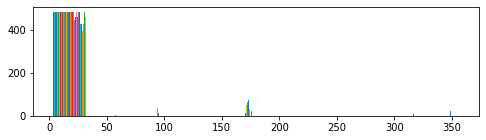

In [14]:
plt.figure(figsize=(8, 2))
angles = ang * (mag > 10)
plt.hist(angles)
plt.show()

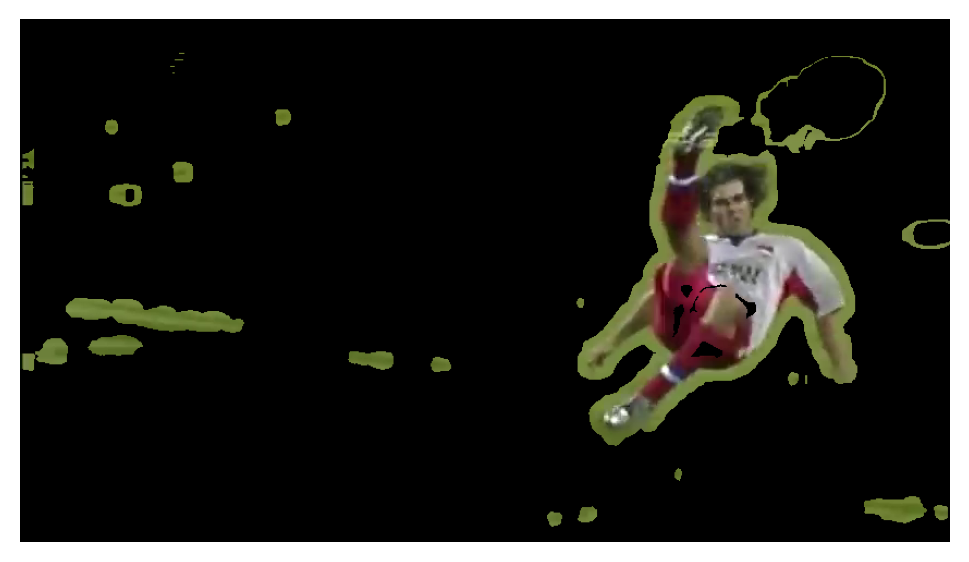

In [15]:
mask = np.where((150 < angles) & (angles < 200), 0, 255)
output = (mag > 1) * mask

img_sub = np.repeat(output.reshape([*output.shape, 1]), 3, axis=2)
img_sub = np.abs(img_sub - 255).astype(np.uint8)
img = cv2.subtract(frame, img_sub)

show_image(img)